Ячейка ниже удалит папку cyrill

И сделает клон ветки из удаленного репо в ваш colab

In [1]:
!rm -rf /content/cyrill
!git clone -b augmentation_pipline --single-branch https://github.com/TimofeyKaliakin/cyrill.git

Cloning into 'cyrill'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (37/37), done.
Receiving objects: 100% (67/67), 97.29 KiB | 837.00 KiB/s, done.
remote: Total 67 (delta 25), reused 62 (delta 20), pack-reused 0 (from 0)
Resolving deltas: 100% (25/25), done.


In [2]:
import sys

sys.path.append('/content/cyrill')

from src.preprocessing.transforms import ScaleAugmentation, ShearAugmentation
from src.preprocessing.configs import PipelineConfig
from src.preprocessing.augmentation_pipeline import AugmentationPipeline
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import torch


In [24]:
ds_test = load_dataset("Timka28/cyrillic", split="test")

# добавляем колонку с индексами
ds_test = ds_test.add_column("idx", list(range(len(ds_test))))

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/462 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

### 2. Инициализация аугментаций

In [41]:
# Аугментации
scale_aug = ScaleAugmentation(scale_range=(0.50, 1.))
shear_aug = ShearAugmentation(
    shear_x_range=(-8.0, 8.0),
    shear_y_range=None,
)

### 3. Конфигурация пайплайна

In [42]:
config = PipelineConfig(
    p_aug=.9,  # 90% изображений будут аугментированы
    augmentations={
        "scale": scale_aug,
        "shear": shear_aug,
    },
    aug_weights={
        "scale": 0.5,
        "shear": 0.5,
    },
    return_params=True,
)

### 4. Создание AugmentationPipeline

In [43]:
aug_pipeline = AugmentationPipeline(
    config=config,
)

### 5. HF transform-функция (адаптер)

In [44]:
# Здесь вам уже нужно подготовить обработку под свою модель
# но главное используйте aug_pipeline(img, idx) передавая idx
def hf_transform(batch):
    images = []
    aug_metas = []

    for img, idx in zip(batch["image"], batch["idx"]):
        img_aug, meta = aug_pipeline(img, idx=idx) # Применяем аугментационный пайплайн

        images.append(img_aug)
        aug_metas.append(meta)

    batch["image"] = images
    batch["aug_meta"] = aug_metas
    return batch

### 5. Применение пайплайна

In [45]:
ds_test_aug = ds_test.with_transform(
    hf_transform,
    columns=["image", "idx"],
    output_all_columns=True,
)

Далее этот датасет можно использовать для обучения модели, инференса и тд. К 30% изображений в нем будет применяться аугментация

### 6. Визуализация результатов

In [46]:
import random

chosen = []
tries = 0

while len(chosen) < 4 and tries < 2000:
    idx = random.randint(0, len(ds_test_aug) - 1)
    batch = ds_test_aug[idx:idx+1]

    meta = batch["aug_meta"][0]
    if meta["applied"]:
        chosen.append(idx)

    tries += 1

original_images = []
augmented_images = []
metas = []

for idx in chosen:
    # оригинал — из исходного датасета
    original_images.append(ds_test[idx]["image"])

    # аугментированное — из with_transform
    sample_aug = ds_test_aug[idx]

    augmented_images.append(sample_aug["image"])
    metas.append(sample_aug["aug_meta"])

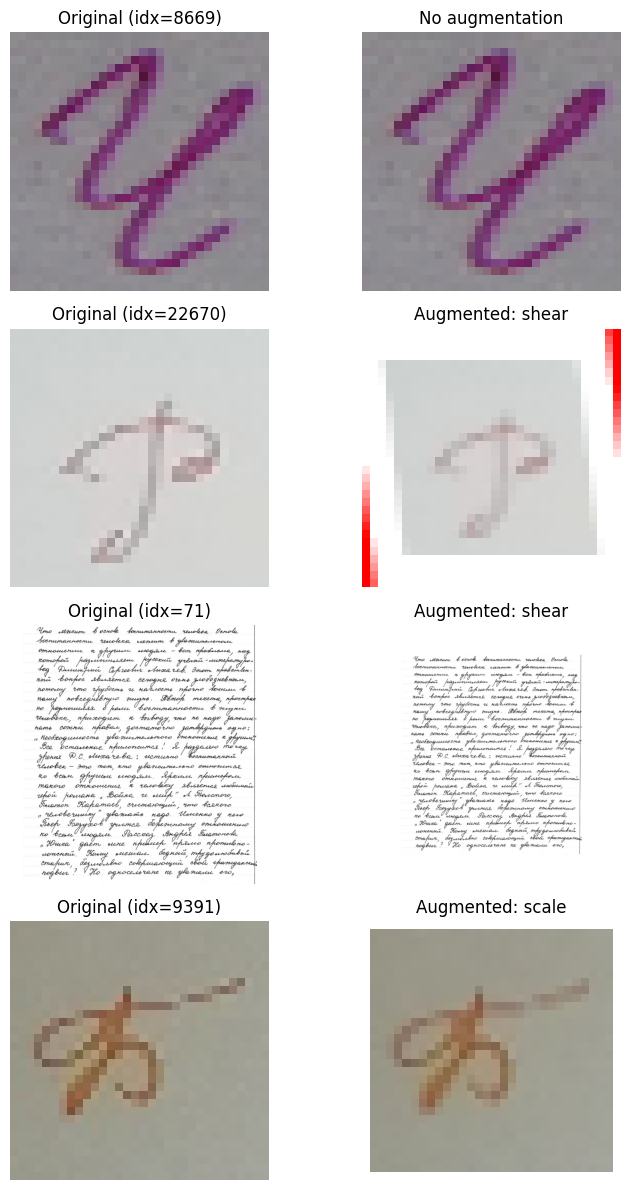

In [47]:
fig, axes = plt.subplots(len(chosen), 2, figsize=(8, 12))

for i, idx in enumerate(chosen):
    # Оригинал
    axes[i, 0].imshow(original_images[i], cmap="gray")
    axes[i, 0].set_title(f"Original (idx={idx})")
    axes[i, 0].axis("off")

    # После ds_test_aug (with_transform)
    axes[i, 1].imshow(augmented_images[i], cmap="gray")

    meta = metas[i]
    if meta["applied"]:
        title = f"Augmented: {meta['name']}"
    else:
        title = "No augmentation"

    axes[i, 1].set_title(title)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

### 7. Посмотреть параметры аугментаций

In [48]:
for idx, meta in zip(chosen, metas):
    print(f"idx={idx}")
    print(meta)
    print("-" * 40)

idx=8669
{'applied': False}
----------------------------------------
idx=22670
{'applied': True, 'name': 'shear', 'params': {'phi_x': 6.2210692392818245, 'phi_y': 0.0, 'kx': 0.10900684657532522, 'ky': 0.0}}
----------------------------------------
idx=71
{'applied': True, 'name': 'shear', 'params': {'phi_x': -0.40423841283754136, 'phi_y': 0.0, 'kx': -0.007055408333443735, 'ky': 0.0}}
----------------------------------------
idx=9391
{'applied': True, 'name': 'scale', 'params': {'scale': 0.9624118974921669}}
----------------------------------------
